In [5]:
## Import system library
import os
import glob

## Import Image Processing library
import cv2
import skimage
import numpy as np
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask
from skimage.filters import threshold_otsu
from skimage.morphology import disk, closing, dilation, erosion, opening
import matplotlib.pyplot as plt
%matplotlib inline

from utils.preprocess import sliding_window

## Import machine learning library
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from utils.lbp import LBP
from utils.vis import draw_bboxes
from utils.dataset import load_yolo_labels
from utils.bboxes import iou, calculate_boxA_percentage
from utils.intensity_transforms import histogram_matching, calculate_mean_histogram


ModuleNotFoundError: No module named 'utils'

In [8]:
## Defind dataset folders

# root_path = '/content/drive/Shareddrives/Wrist_fracture_detectiom/ML/Dataset'
root_path = '../MLDataset/crop_data'

img_train_folder = 'train'
img_test_folder = 'test'
label_folder = 'labels'
image_folder = 'images'

In [4]:
def preprocess(image, mean_histogram=None, dilate_num=4, intensity_crop=1, outputbitdepth=8, unsharp=True):
    """
    Processes a single image by applying histogram matching, thresholding,
    multiple dilations, and closing.

    Args:
    - image_path (str/numpy): Path to the image file or numpy array of the image.
    - mean_histogram (array-like): The histogram to match. If None, don't match histogram.
    - dilate_num (int): Number of times dilation should be applied.
    - intensity_crop (int): Percentage of the image intensity to crop.
    - outputbitdepth (int): The bit depth of the output image.

    Returns:
    - final_image (ndarray): The processed image.
    """
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)
    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
        # Method 1: Adaptive Histogram Equalization (CLAHE)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))
    
    return final_image


## Histogram Matching

## Extract Features

In [5]:
mean_histogram = np.load('mean_hist.npy')

In [ ]:
intensity_crop = 0
outputbitdepth = 8 
unsharp = True
dilate_num = 1
erosion_num = 4

for j, image_path in enumerate(glob.glob(os.path.join(root_path, image_folder, img_train_folder, 'fracture/*.png'))):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image.ndim == 3:
        image = rgb2gray(image)

    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)

    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)

    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)

    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh

    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)

    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)

    # Apply multiple erosions
    eroded_mask = closed_mask
    for _ in range(erosion_num):
        eroded_mask = erosion(eroded_mask, selem)
        
    # Apply opening to the eroded mask
    opened_mask = opening(eroded_mask, selem)

    # Apply closing to the opened mask
    closed_mask = closing(opened_mask, selem)

    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))

    plt.figure(figsize=(10, 10))
    plt.imshow(final_image, cmap='gray')
    plt.axis('off')
    plt.show()

    if j > 20:
        break

/Users/huytrq/miniconda3/envs/py11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/huytrq/miniconda3/envs/py11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


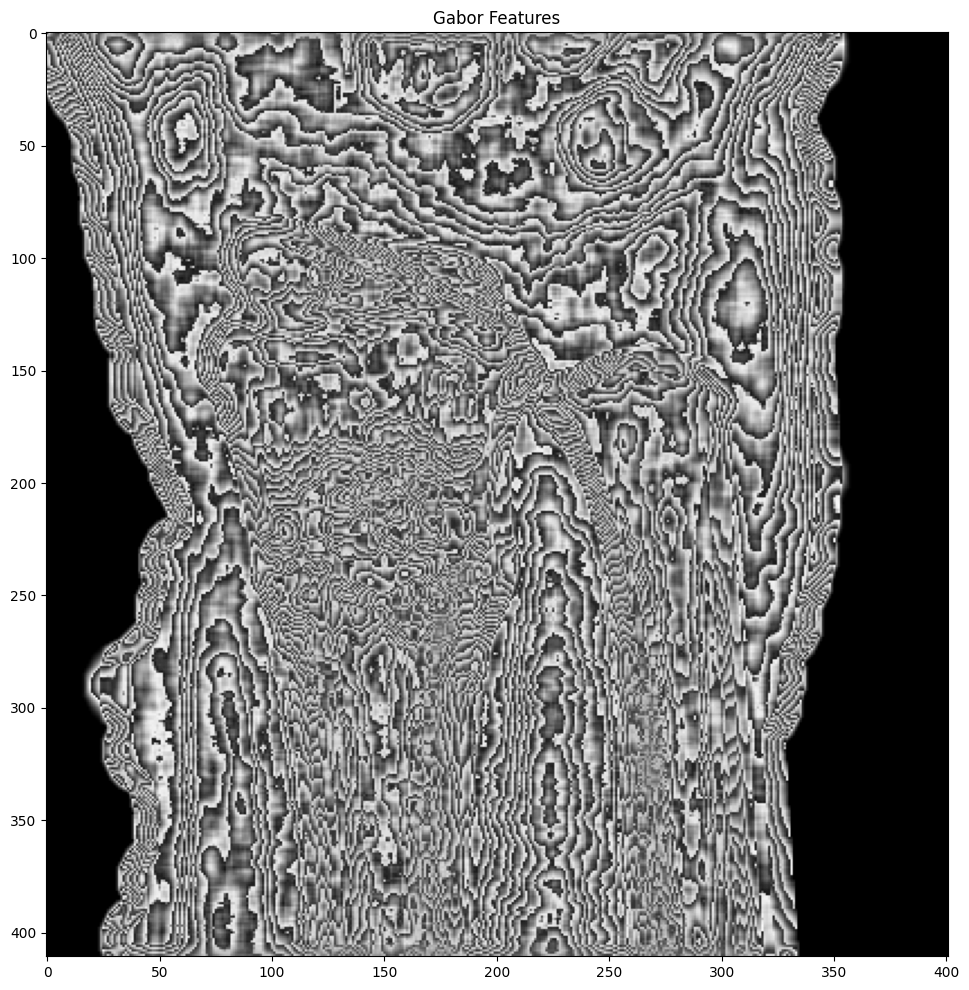

In [23]:
import numpy as np
import cv2
from scipy.ndimage import convolve
import torch
import torchvision.models as models

class GaborDescriptor:
    def __init__(self, use_alexnet=False, padding='nopad', normalize=True, lambdas=[1.0, 2.0, 3.0], thetas=np.arange(0, np.pi, np.pi / 6), sigmas=[3, 5]):
        self.use_alexnet = use_alexnet
        self.lambdas = lambdas
        self.thetas = thetas
        self.sigmas = sigmas
        self.normalize = normalize
        self.padding = padding
        self.kernels = self.build_kernels()
    
    def build_kernels(self):
        if self.use_alexnet:
            return self.build_alexnet_kernels()
        else:
            return self.build_gabor_kernels()
    
    def build_gabor_kernels(self):
        kernels = []
        for theta in self.thetas:
            for sigma in self.sigmas:
                for lambd in self.lambdas:
                    ksize = int(6 * sigma + 1)  # Kernel size, typically 6*sigma + 1
                    gamma = 1.0                # Spatial aspect ratio
                    psi = 0                    # Phase offset
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
                    kernels.append(kernel)
        if self.normalize:
            kernels = [kernel / np.linalg.norm(kernel) for kernel in kernels]
        return kernels

    def build_alexnet_kernels(self):
        # Load the pre-trained AlexNet model
        alexnet = models.alexnet(pretrained=True)
        
        # Extract the first convolutional layer's weights
        conv1_weights = alexnet.features[0].weight.data.numpy()
        conv1_weights_avg = np.mean(conv1_weights, axis=1, keepdims=True)
        if self.normalize:
            conv1_weights_avg -= conv1_weights_avg.min()
            conv1_weights_avg /= conv1_weights_avg.max()
        
        # Extract the first filter from the first channel
        # and prepare it as a single kernel
        kernels = [conv1_weights_avg[i, 0, :, :] for i in range(conv1_weights_avg.shape[0])]
        
        return kernels

    def apply_pooling(self, responses, pool_size=2):
        return np.mean(responses, axis=0)

    def __call__(self, image):
        responses = self.apply_filters(image)
        pooled_response = self.apply_pooling(responses)
        return pooled_response

    def apply_filters(self, image):
        responses = []
        for kernel in self.kernels:
            if self.padding == 'nopad':
                filtered = convolve(image, kernel, mode='constant', cval=0.0)
            else:
                filtered = convolve(image, kernel, mode='reflect')
            responses.append(filtered)
        return np.array(responses)

# image = preprocess(image)

# Initialize GaborDescriptor
# Set `use_alexnet=True` to use the first filter from AlexNet
gabor_descriptor = GaborDescriptor(use_alexnet=True, padding='nopad', normalize=True)

# Apply filters to the image
gabor_features = gabor_descriptor(image)

plt.figure(figsize=(12, 12))
plt.imshow(gabor_features, cmap='gray')
plt.title('Gabor Features')
plt.show()

In [83]:
def extract_gabor_features(image, ksize=7):
    filters = []
    for theta in np.arange(0, np.pi, np.pi / 4):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        filters.append(kern)
    
    features = []
    for kern in filters:
        filtered = cv2.filter2D(image, cv2.CV_8UC3, kern)
        features.append(filtered)
    
    return features

In [86]:
features = extract_gabor_features(image)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import gabor

In [ ]:
mode = 'train'
class_name = 'fracture'

for idx, image in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    if isinstance(image, str):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image, np.ndarray):
        if image.ndim == 3:
            image = rgb2gray(image)
    else:
        raise ValueError("Image must be a file path or numpy array.")
    
    if unsharp:
        image = ((unsharp_mask(image, radius=2, amount=1))*255).clip(0, 255).astype(np.uint8) # unsharp mask to enhance edges

    ## Histogram equalization
    image = exposure.rescale_intensity(image, in_range=(np.percentile(image, intensity_crop), np.percentile(image, (100-intensity_crop))))
    image = exposure.equalize_adapthist(image)
    
    ## Normalize image
    image = cv2.normalize(image, dst=None, alpha=0, beta=int((pow(2, outputbitdepth))-1), norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply histogram matching (assuming this function is defined elsewhere)
    if mean_histogram is not None:  
        image = histogram_matching(image, mean_histogram)
    
    # Apply Otsu's thresholding
    thresh = threshold_otsu(image)
    binary_mask = image > thresh
    
    # Apply multiple dilations
    selem = disk(4)
    dilated_mask = binary_mask
    for _ in range(dilate_num):
        dilated_mask = dilation(dilated_mask, selem)
    
    # Apply closing to the dilated mask
    closed_mask = closing(dilated_mask, selem)
    
    # Apply the mask to the original image using a bitwise AND operation
    final_image = cv2.bitwise_and(image, image, mask=np.uint8(closed_mask * 255))
    
    break


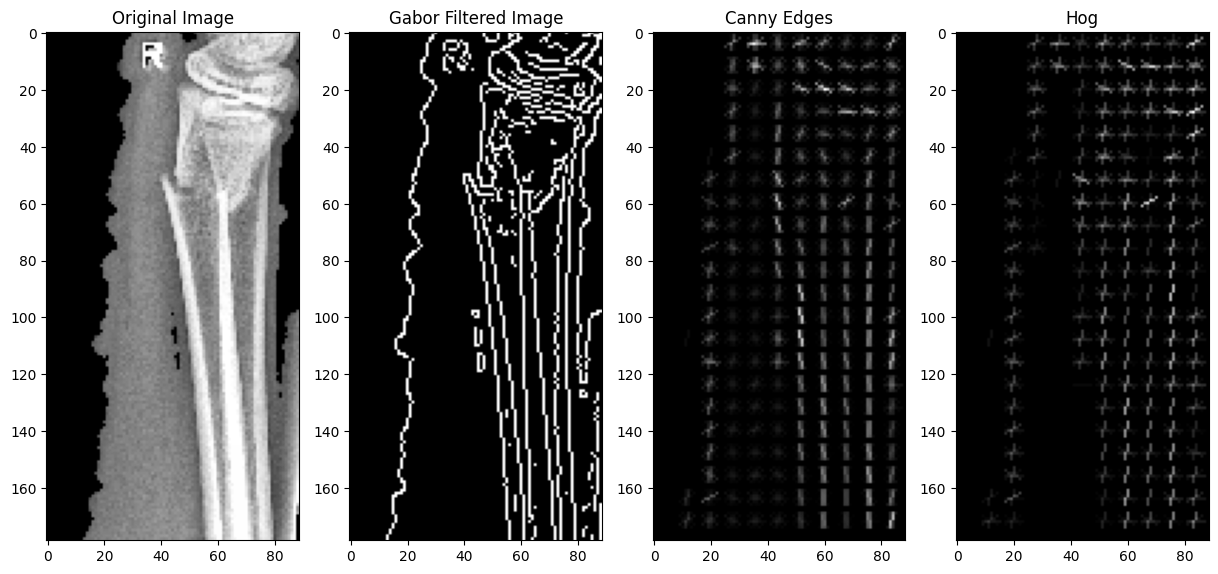

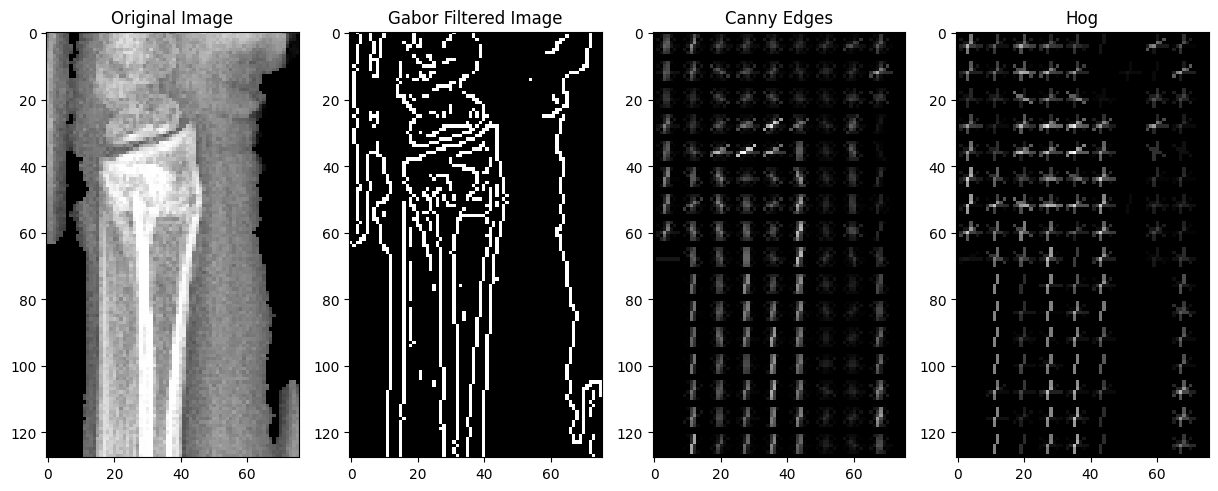

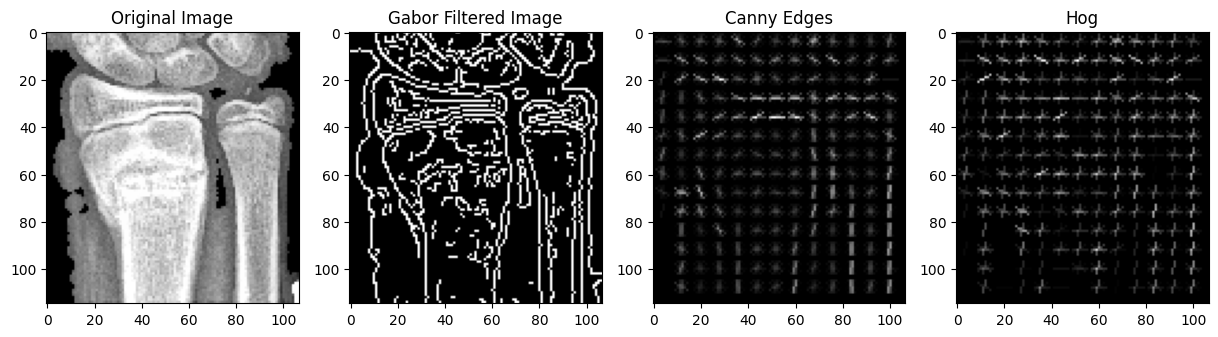

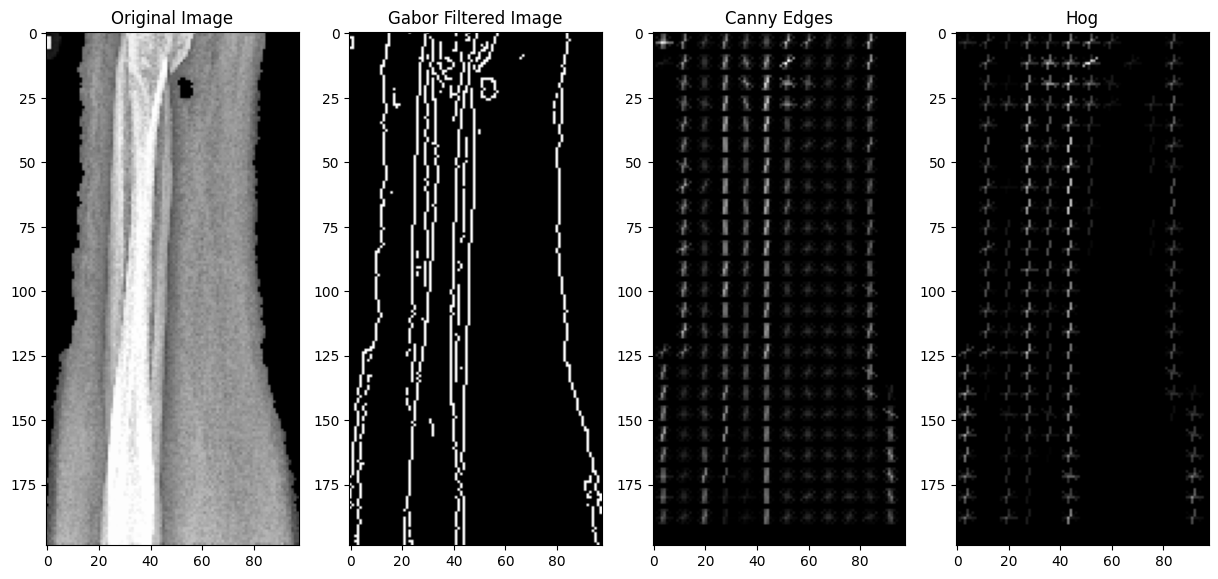

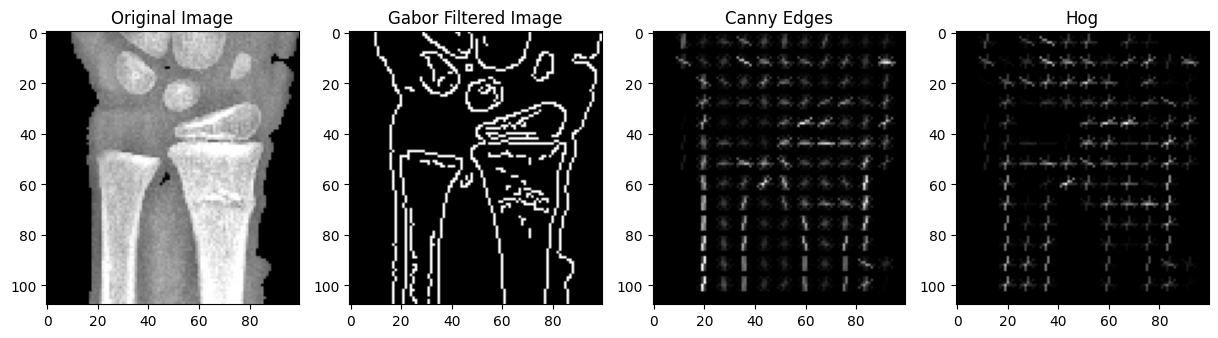

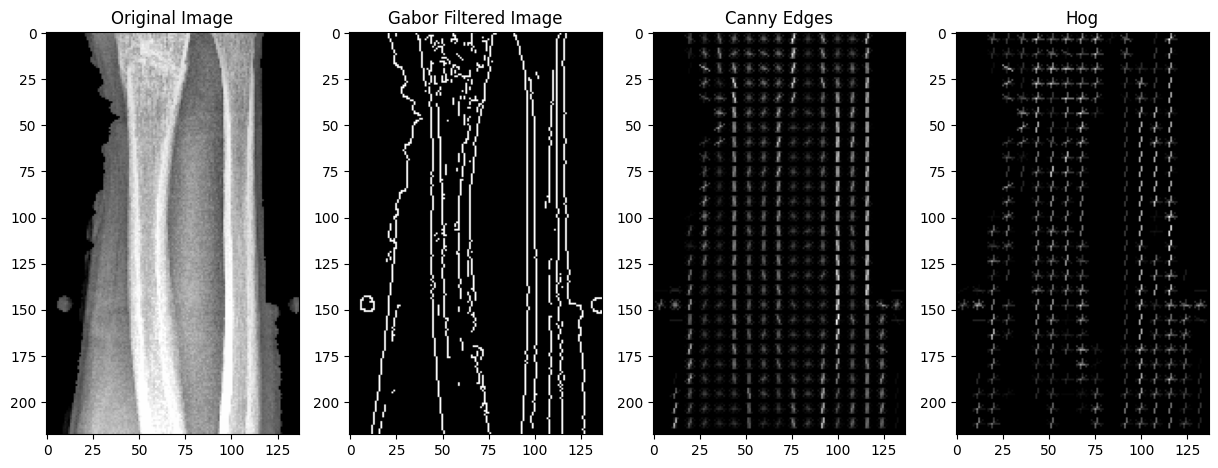

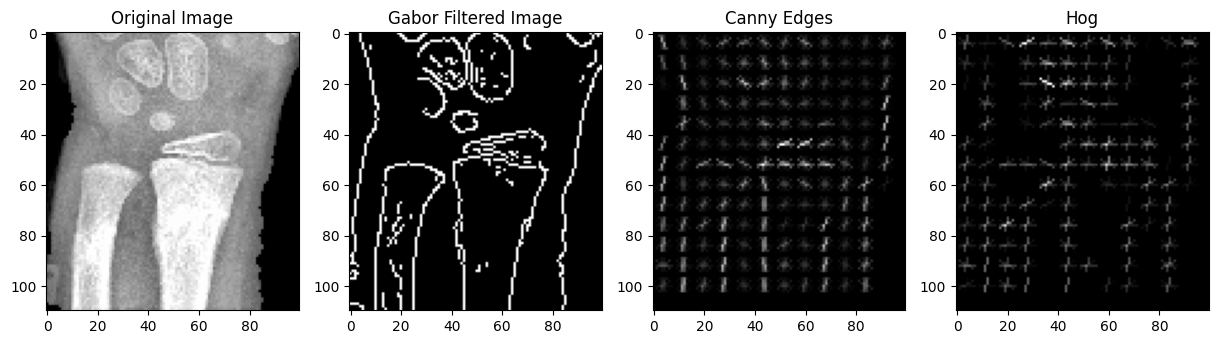

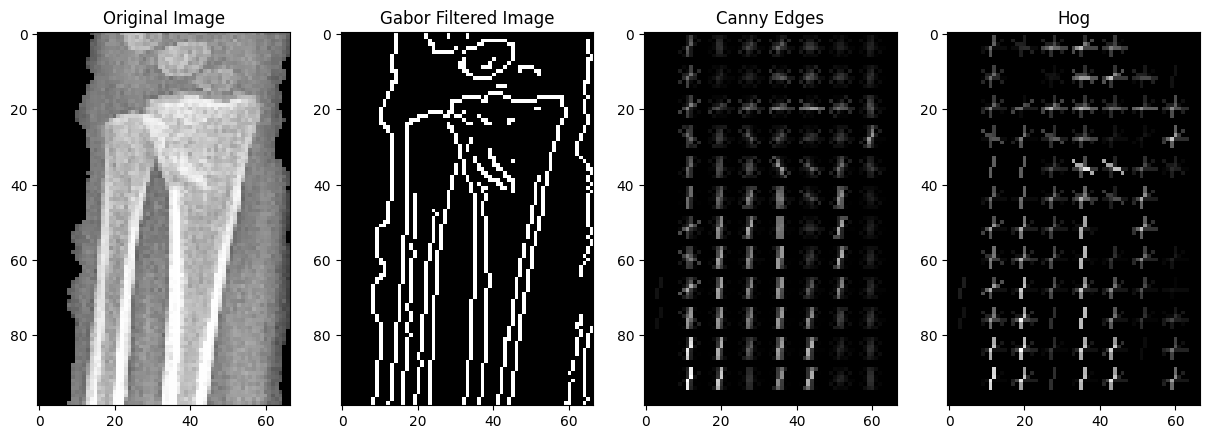

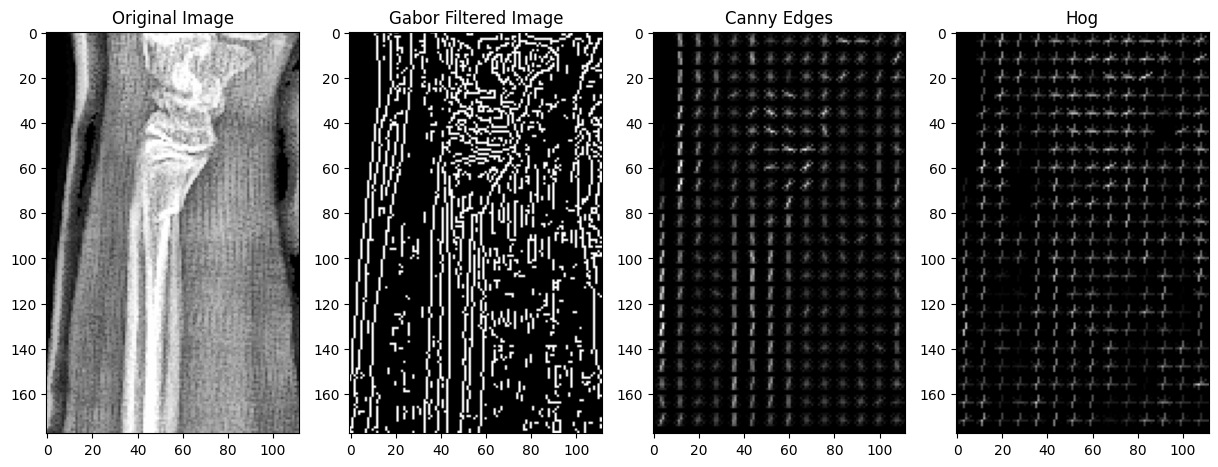

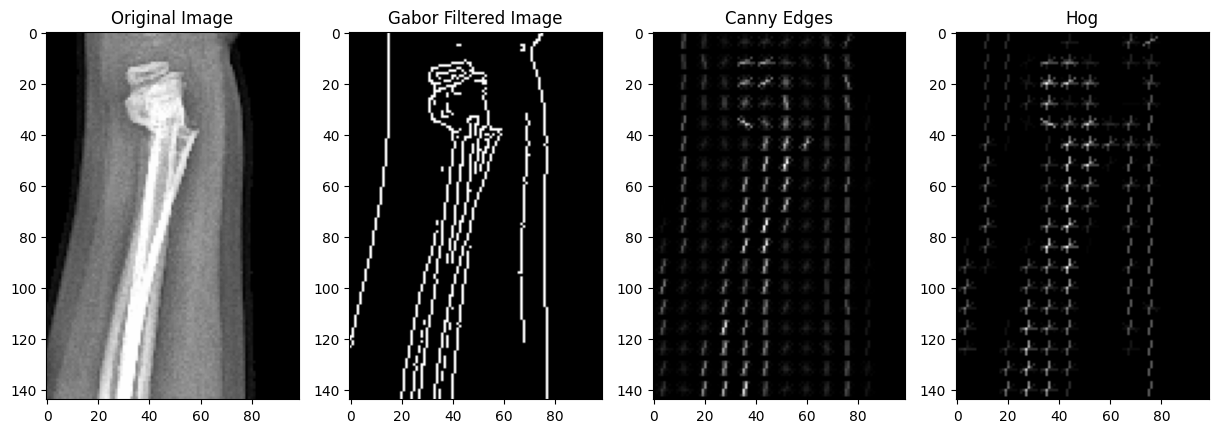

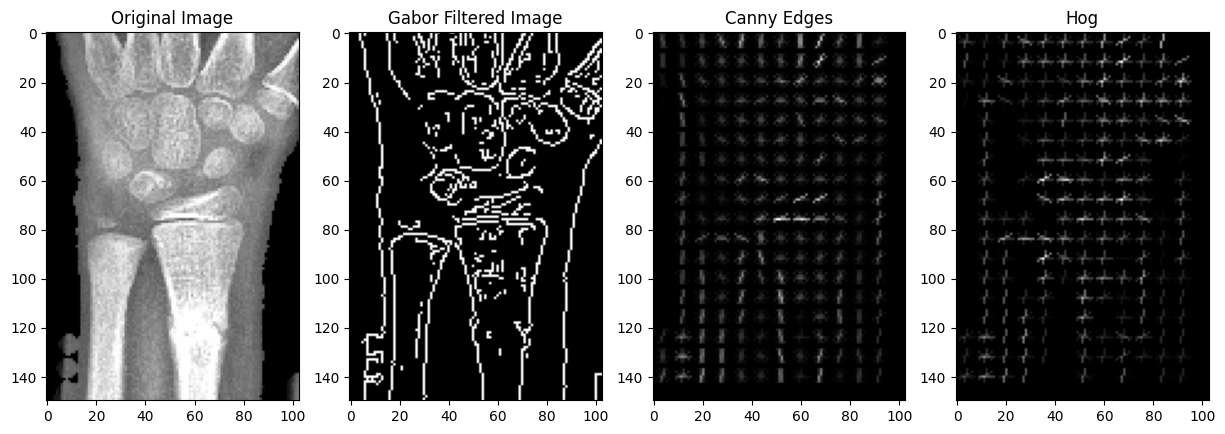

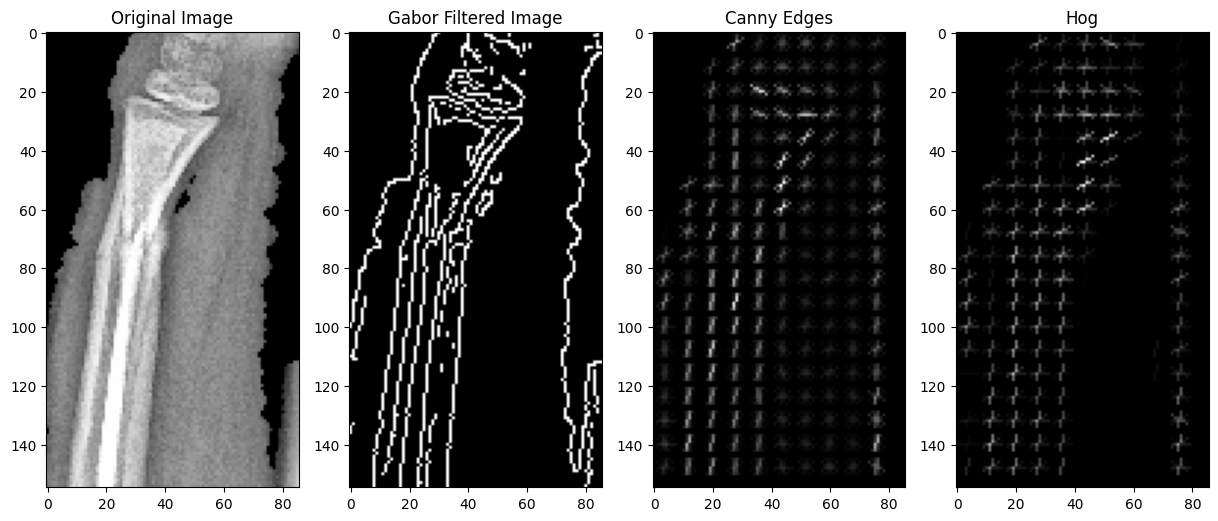

In [107]:

from skimage.feature import hog
from skimage.filters import gabor, gabor_kernel
from scipy.ndimage import convolve

mode = 'train'
class_name = 'fracture'

# Function to apply a Gabor kernel to an image
def apply_gabor_kernel(image, kernel):
    filtered = np.sqrt(convolve(image, np.real(kernel))**2 + convolve(image, np.imag(kernel))**2)
    # filtered = convolve(image, np.real(kernel)) + convolve(image, np.imag(kernel))
    return filtered

for idx, image in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    # Load the image
    image = preprocess(image)
    image = skimage.measure.block_reduce(image, (4,4), np.max)

    frequency = 0.6
    sigma_x = 1
    sigma_y = 1
    n_stds = 3
    offset = 0
    mode = 'reflect'
    cval = 0
    
    # Parameters for Gabor kernels
    frequencies = [0.8]
    thetas = [np.pi/4, 3*np.pi/4]

    filtered_image = 0
    for i, frequency in enumerate(frequencies):
        for j, theta in enumerate(thetas):
            kernel = gabor_kernel(frequency, theta=theta)
            filtered_image = apply_gabor_kernel(image, kernel)
            
    filtered_image = cv2.normalize(filtered_image.astype(np.uint8), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Use the Canny edge detector
    edges = cv2.Canny(image, 150, 200)
    
    
    fd, hog_image = hog(edges, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)
    
    fd, hog_image1 = hog(image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)

    # Display the results
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title('Gabor Filtered Image')
    plt.imshow(edges, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title('Canny Edges')
    plt.imshow(hog_image1, cmap='gray')
    
    plt.subplot(1, 4, 4)
    plt.title('Hog')
    plt.imshow(hog_image, cmap='gray')

    plt.show()
    if idx > 10:
        break

In [9]:
from skimage.feature import hog
from utils.dataset import resize_keep_aspect_ratio

for idx, image in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    # Load the image
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    image = skimage.measure.block_reduce(image, (3,3), np.max)
    
    image = preprocess(image)
    image1 = cv2.resize(image, (64, 64))
    # image = resize_keep_aspect_ratio(image, (64, 64))
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True)

    # Rescale the HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Display the results
    plt.figure(figsize=(30, 15))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title('HOG Visualization')
    plt.imshow(hog_image, cmap='gray')

    plt.show()

ModuleNotFoundError: No module named 'utils'

In [10]:
image = cv2.imread('MLDataset/images/train/fracture/0160_0598179425_01_WRI-L1_F009.png', cv2.IMREAD_GRAYSCALE)
image = skimage.measure.block_reduce(image, (4,4), np.mean)

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.show()


[ WARN:0@33.449] global loadsave.cpp:248 findDecoder imread_('MLDataset/images/train/fracture/0160_0598179425_01_WRI-L1_F009.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'ndim'

In [13]:
image.shape

(338, 226)

In [20]:
import os
import cv2
import numpy as np
import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def divide_image_into_tiles(image, tile_size):
    tiles = []
    for y in range(0, image.shape[0], tile_size):
        for x in range(0, image.shape[1], tile_size):
            tile = image[y:y + tile_size, x:x + tile_size]
            if tile.shape[0] == tile_size and tile.shape[1] == tile_size:
                tiles.append(tile)
    return tiles

def compute_histogram(tile, bins=32):
    hist = cv2.calcHist([tile], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def kmeans_clustering(histograms, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(histograms)
    return kmeans

def visualize_clusters(image, tile_size, labels, n_clusters):
    clustered_image = np.zeros_like(image)
    label_idx = 0

    colors = plt.cm.get_cmap('hsv', n_clusters)

    for y in range(0, image.shape[0], tile_size):
        for x in range(0, image.shape[1], tile_size):
            if y + tile_size <= image.shape[0] and x + tile_size <= image.shape[1]:
                color = np.array(colors(labels[label_idx])[:3]) * 255
                color = color.astype(np.uint8)
                clustered_image[y:y + tile_size, x:x + tile_size] = color
                label_idx += 1

    return clustered_image

def overlay_clusters_on_image(original_image, clustered_image, alpha=0.5):
    overlay_image = cv2.addWeighted(original_image, alpha, clustered_image, 1 - alpha, 0)
    return overlay_image

mode = 'train'
class_name = 'fracture'
mean_hist = np.load('mean_hist.npy')

for idx, image_path in enumerate(glob.glob(os.path.join(root_path, image_folder, mode, class_name, '*.png'))):
    # Example usage
    # image = cv2.imread('/Users/huytrq/Workspace/unicas/AIA&ML/Wrist-Fracture-Detection/test.png')
    # image = histogram_matching(image, mean_hist)
    image = preprocess('test.png')
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    tile_size = 4
    
    # # padding image to be divisible by tile size
    # h, w = image.shape[:2]
    # h_pad = tile_size - h % tile_size
    # w_pad = tile_size - w % tile_size
    # image = cv2.copyMakeBorder(image, 0, h_pad, 0, w_pad, cv2.BORDER_REFLECT)

    # Divide image into tiles
    tiles = divide_image_into_tiles(image, tile_size)

    # Compute histograms for each tile
    histograms = [compute_histogram(tile) for tile in tiles]

    # Perform K-means clustering
    n_clusters = 3
    kmeans = kmeans_clustering(histograms, n_clusters)
    labels = kmeans.labels_

    # Visualize the clusters
    clustered_image = visualize_clusters(image, tile_size, labels, n_clusters)

    # Overlay the clustered image on the original image
    overlay_image = overlay_clusters_on_image(image, clustered_image, alpha=0.5)
    plt.imshow(overlay_image)
    plt.show()
    if idx > 1:
        break


FileNotFoundError: [Errno 2] No such file or directory: 'mean_hist.npy'

In [30]:
import cv2
import numpy as np
import os
from glob import glob

def load_yolo_labels(label_path, image_shape):
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x_center *= image_shape[1]
            y_center *= image_shape[0]
            width *= image_shape[1]
            height *= image_shape[0]
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)
            labels.append((class_id, x_min, y_min, x_max, y_max))
    return labels

def create_heatmap(labels, image_shape):
    heatmap = np.zeros(image_shape[:2], dtype=np.float32)
    
    for (class_id, x_min, y_min, x_max, y_max) in labels:
        heatmap[y_min:y_max, x_min:x_max] += 1
    
    return heatmap

def overlay_heatmap(image, heatmap, alpha=0.6, colormap=cv2.COLORMAP_JET):
    heatmap_color = cv2.applyColorMap(heatmap.astype(np.uint8), colormap)
    overlay = cv2.addWeighted(image, alpha, heatmap_color, 1 - alpha, 0)
    return overlay


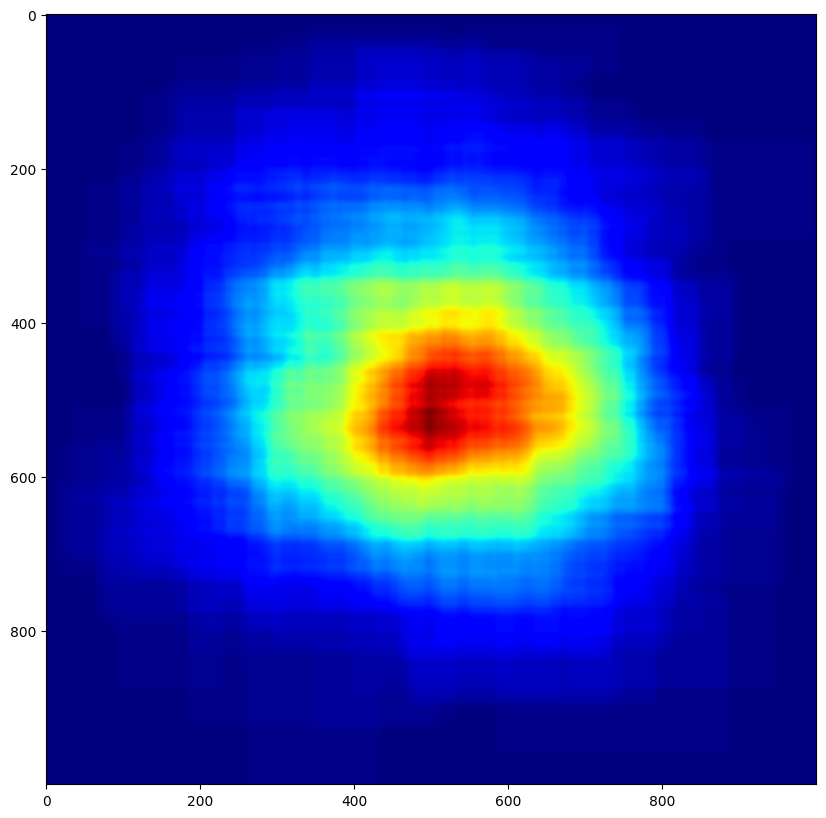

In [69]:

def generate_heatmap_from_folder(image_folder, label_folder, blur=False):
    image_files = glob(os.path.join(image_folder, '*.png'))  # Adjust the extension as needed
    heatmap = None
    image_shape = (1000, 1000)
    
    for image_path in image_files:
        label_path = os.path.join(label_folder, os.path.basename(image_path).replace('.png', '.txt'))
        if not os.path.exists(label_path):
            continue
        
        image = cv2.imread(image_path)
        if heatmap is None:
            # image_shape = image.shape
            heatmap = np.zeros(image_shape[:2], dtype=np.float32)
        
        labels = load_yolo_labels(label_path, image_shape)
        if labels:
            heatmap += create_heatmap(labels, image_shape)
    
    if heatmap is not None and np.any(heatmap):  # Ensure heatmap is not empty
        if blur:
            heatmap = cv2.GaussianBlur(heatmap, (15, 15), 0)
        
        heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    return heatmap


# Example usage
image_folder = '../MLDataset/crop_data/images/train/fracture/'
label_folder = '../MLDataset/crop_data/labels/train/fracture/'

heatmap = generate_heatmap_from_folder(image_folder, label_folder, blur=True)

plt.figure(figsize=(10, 10))
plt.imshow(heatmap, cmap='jet')
np.save('crop_heatmap.npy', heatmap)

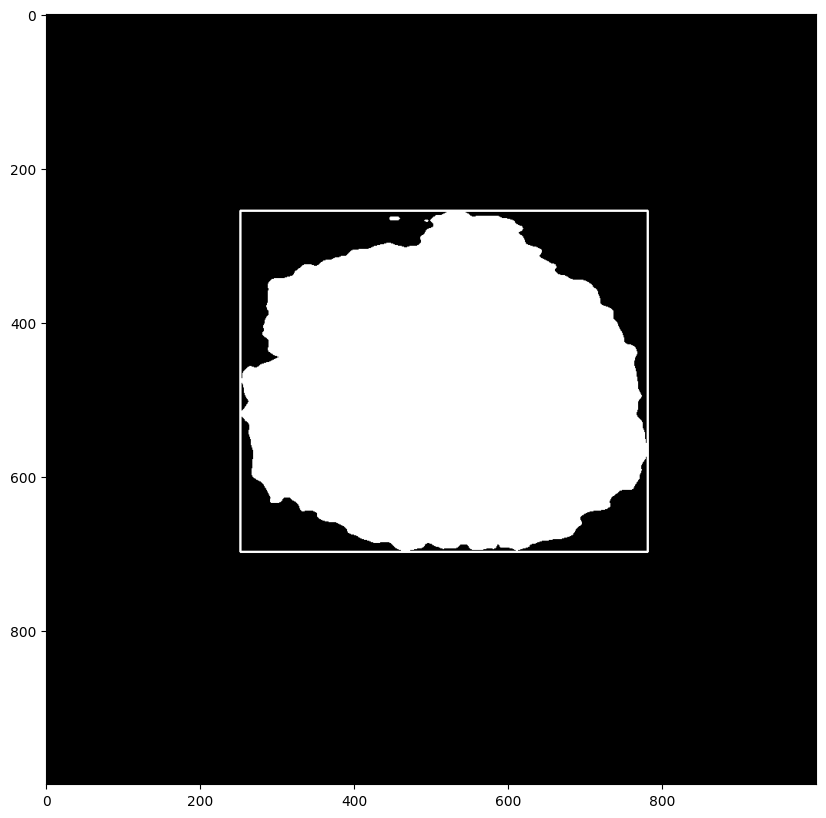

In [68]:
# Thresholding the image to segment the heatmap
_, segmented_image = cv2.threshold(heatmap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
bounding_boxes = [cv2.boundingRect(contour) for contour in contours][-1]
x, y, w, h = bounding_boxes
cv2.rectangle(segmented_image, (x, y), (x + w, y + h), (255, 255, 255), 2)
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image, cmap='gray')
plt.show()


In [66]:
bounding_boxes

[(491, 267, 6, 3), (446, 263, 14, 5), (252, 255, 529, 443)]

In [49]:
contours[2]

array([[[527, 255]],

       [[526, 256]],

       [[524, 256]],

       ...,

       [[542, 256]],

       [[539, 256]],

       [[538, 255]]], dtype=int32)